# 결정 트리(Decision Tree)

* 분류와 회귀에 사용되는 지도 학습 방법
* 데이터 특성으로 부터 추론된 결정 규칙을 통해 값을 예측
* **if-then-else** 결정 규칙을 통해 데이터 학습
* 트리의 깊이가 깊을 수록 복잡한 모델
* 결정 트리 장점
  * 이해와 해석이 쉽다
  * 시각화가 용이하다
  * 많은 데이터 전처리가 필요하지 않다
  * 수치형과 범주형 데이터 모두를 다룰 수 있다


In [1]:
import pandas as pd
import numpy as np
import graphviz #tree 시각화
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

<ipython-input-1-b3c94a6f6482>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-whitegrid'])


## 분류 - `DecisionTreeClassifier()`

* `DecisionTreeClassifier`는 분류를 위한 결정트리 모델
* 두개의 배열 X, y를 입력 받음
  * X는 [n_samples, n_features] 크기의 데이터 특성 배열
  * y는 [n_samples] 크기의 정답 배열

### 하이퍼 파라미터 

* criterion : {'gini', 'entropy', 'log_loss'}
  * ```default = 'gini'```

* max_depth : int
  *  ```default = None```
    + If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
  * the maximum depth of tree

* min_samples_split : int
  *  ```default = 2```
  * The minimum number of samples required to split an internal node

* min_samples_leaf : int or float
  * ```default = 1 ```
  * The minimum number of samples required to be at a leaf node.
  *  if min_smaples_leaf > min_samples_split then min_samples leaf consider first

* max_features : int, float, {“auto”, “sqrt”, “log2”}
  * ```default = None```
  * The number of features to consider when looking for the best split
  * tree를 형성할때 사용하는 features 의 갯수를 지정해 주는게 아니다 
  * 분할을 할때 고려할 features의 갯수를 지정해 주는것
  * overfitting 방지를 위해 사용

* max_leaf_nodes : int
  * ```default = None ```
  * 리프노드의 최대 갯수 설정

* ccp_alphanon-negative : float 
  * ```default=0.0```
  * post pruning method
  * overfitting 방지를 위해 사용

### 붓꽃 데이터 학습

In [38]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = load_iris(return_X_y = True)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 2023)
                                          

#### 하이퍼파리미터 조절

##### parameter name

In [40]:
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier().get_params().items()

dict_items([('ccp_alpha', 0.0), ('class_weight', None), ('criterion', 'gini'), ('max_depth', None), ('max_features', None), ('max_leaf_nodes', None), ('min_impurity_decrease', 0.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('random_state', None), ('splitter', 'best')])

##### pre-pruning

In [41]:
from sklearn.model_selection import GridSearchCV
import multiprocessing
import sklearn.model_selection as ms


model = DecisionTreeClassifier()
param_dict = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth' : [2,3,4],
              'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [1,2,3]}

gs = GridSearchCV(model, param_grid = param_dict,
                  cv = ms.StratifiedKFold(shuffle = True, random_state = 2023),
                  n_jobs = multiprocessing.cpu_count())

gs.fit(X_train, y_train)

print(f'최적 파라미터 : {gs.best_estimator_}')
print(f'최종 점수 : {gs.score(X_test, y_test)}')

res = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
res[['rank_test_score', 'mean_test_score', 'param_criterion',
     'param_min_samples_leaf', 'param_min_samples_split','param_max_depth']].head(5)

최적 파라미터 : DecisionTreeClassifier(max_depth=3)
최종 점수 : 0.9666666666666667


,rank_test_score,mean_test_score,param_criterion,param_min_samples_leaf,param_min_samples_split,param_max_depth
40,1,0.941667,entropy,2,3,3
38,1,0.941667,entropy,1,4,3
37,1,0.941667,entropy,1,3,3
36,1,0.941667,entropy,1,2,3
47,1,0.941667,entropy,1,4,4


##### post-pruning 
* cost complexity pruning(using ccp_alpha)

gridsearch 이용

In [6]:
ccp_model = DecisionTreeClassifier()
path = ccp_model.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00666667, 0.00810811, 0.04713178, 0.256652  ,
        0.33333333]),
 'impurities': array([0.        , 0.01333333, 0.02954955, 0.07668133, 0.33333333,
        0.66666667])}

In [7]:
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as ms

ccp = path.ccp_alphas
param_dict = {'ccp_alpha' : ccp}

ccp_gs = GridSearchCV(ccp_model, 
                  param_grid = param_dict,
                  cv = ms.StratifiedKFold(shuffle = True, random_state = 2023))
ccp_gs.fit(X_train, y_train)

print(f'최적 파라미터 : {ccp_gs.best_estimator_}')
print(f'최종 점수 : {ccp_gs.score(X_test, y_test)}')

res = pd.DataFrame(ccp_gs.cv_results_).sort_values('rank_test_score')
res[['rank_test_score', 'mean_test_score', 'param_ccp_alpha']].head(5)

최적 파라미터 : DecisionTreeClassifier(ccp_alpha=0.006666666666666665)
최종 점수 : 0.9666666666666667


,rank_test_score,mean_test_score,param_ccp_alpha
1,1,0.941667,0.006667
0,2,0.933333,0.0
2,2,0.933333,0.008108
3,4,0.925000,0.047132
4,5,0.866667,0.256652


for문 이용

In [8]:
clfs = []
ccp_alphas = path.ccp_alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

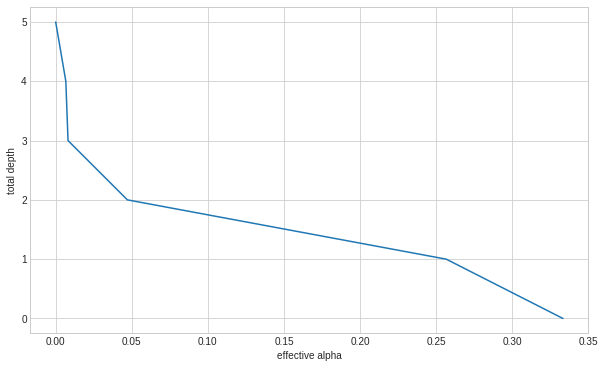

In [9]:
#마지막은 tree깊이가 0

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas, tree_depths)
plt.xlabel("effective alpha")
plt.ylabel("total depth")

[0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.6666666666666666, 0.3333333333333333] 
 [0.         0.00666667 0.00810811 0.04713178 0.256652   0.33333333]


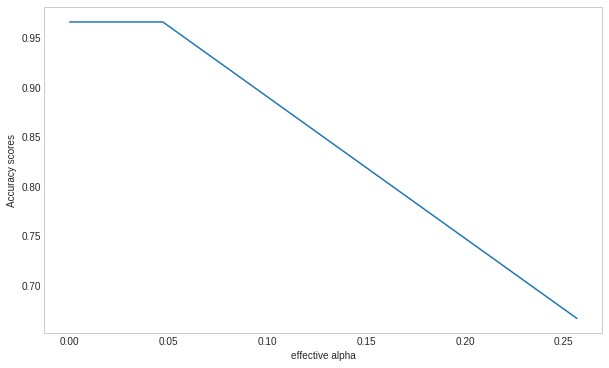

In [10]:
from sklearn.metrics import accuracy_score

acc_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")
print(acc_scores,'\n', ccp_alphas)

#### 결정 트리 시각화

In [66]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier()

##### 텍스트를 통한 시각화

In [62]:
from sklearn import tree

r = tree.export_text(decision_tree = model,
                     feature_names = iris.feature_names)
print(r)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- sepal length (cm) <= 5.05
|   |   |   |   |--- class: 1
|   |   |   |--- sepal length (cm) >  5.05
|   |   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2



##### plot_tree를 사용한 시각화

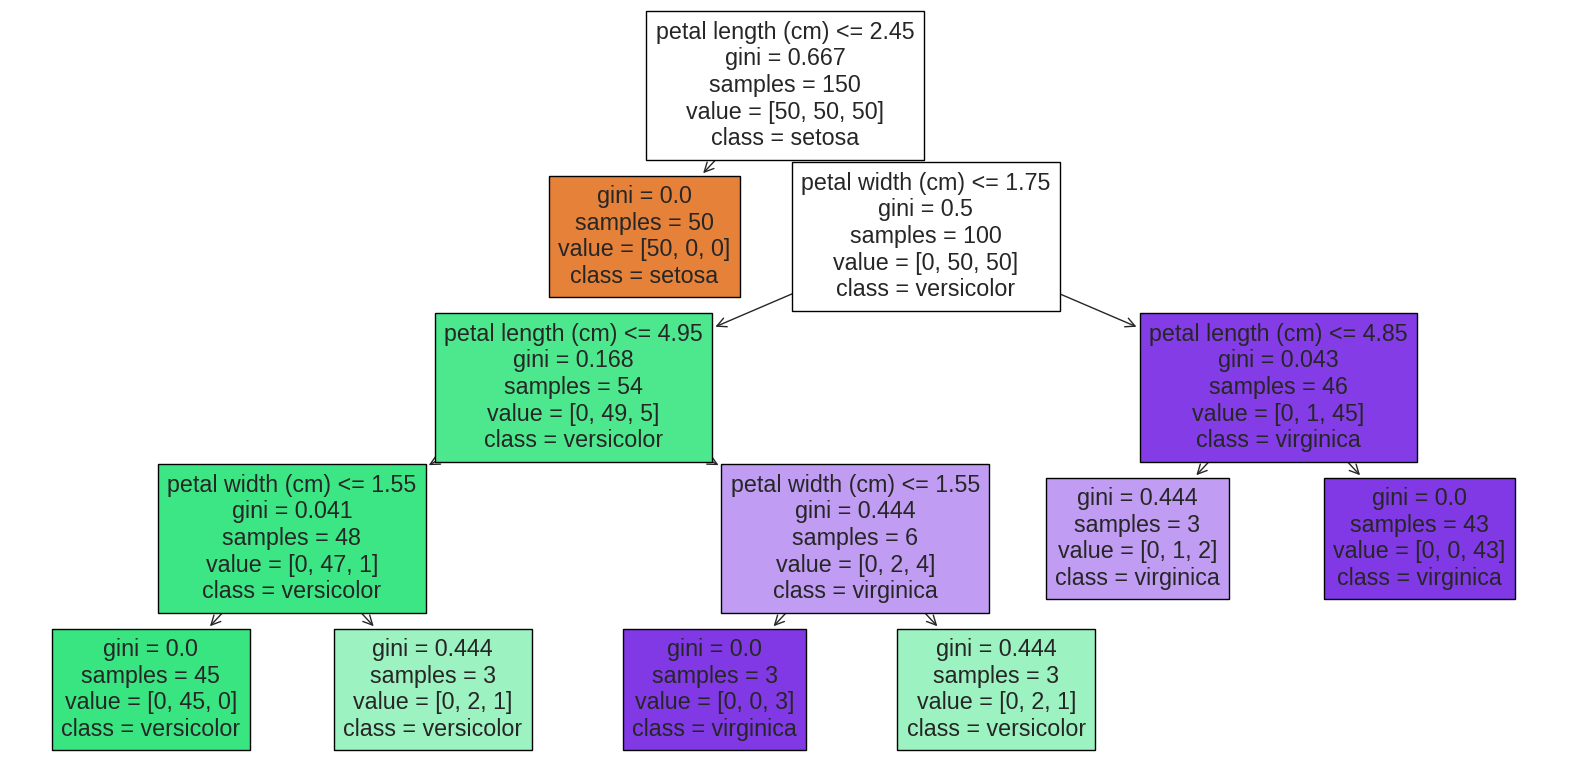

In [65]:
plt.figure(figsize=(20,10), dpi = 100)
tree.plot_tree(model, 
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled = True)
plt.show()

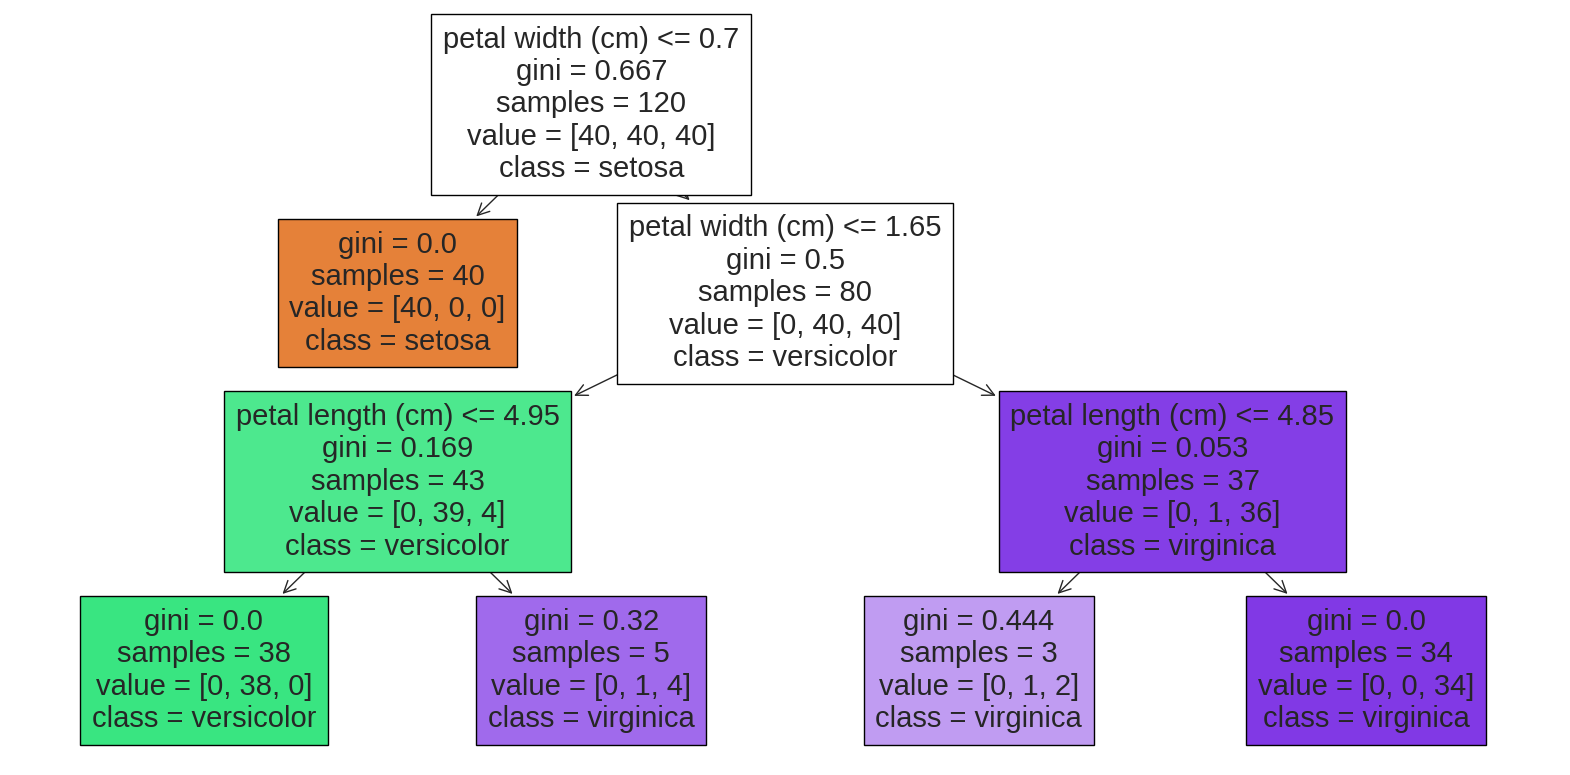

In [58]:
plt.figure(figsize=(20,10), dpi = 100)
tree.plot_tree(gs.best_estimator_, 
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled = True)
plt.show()

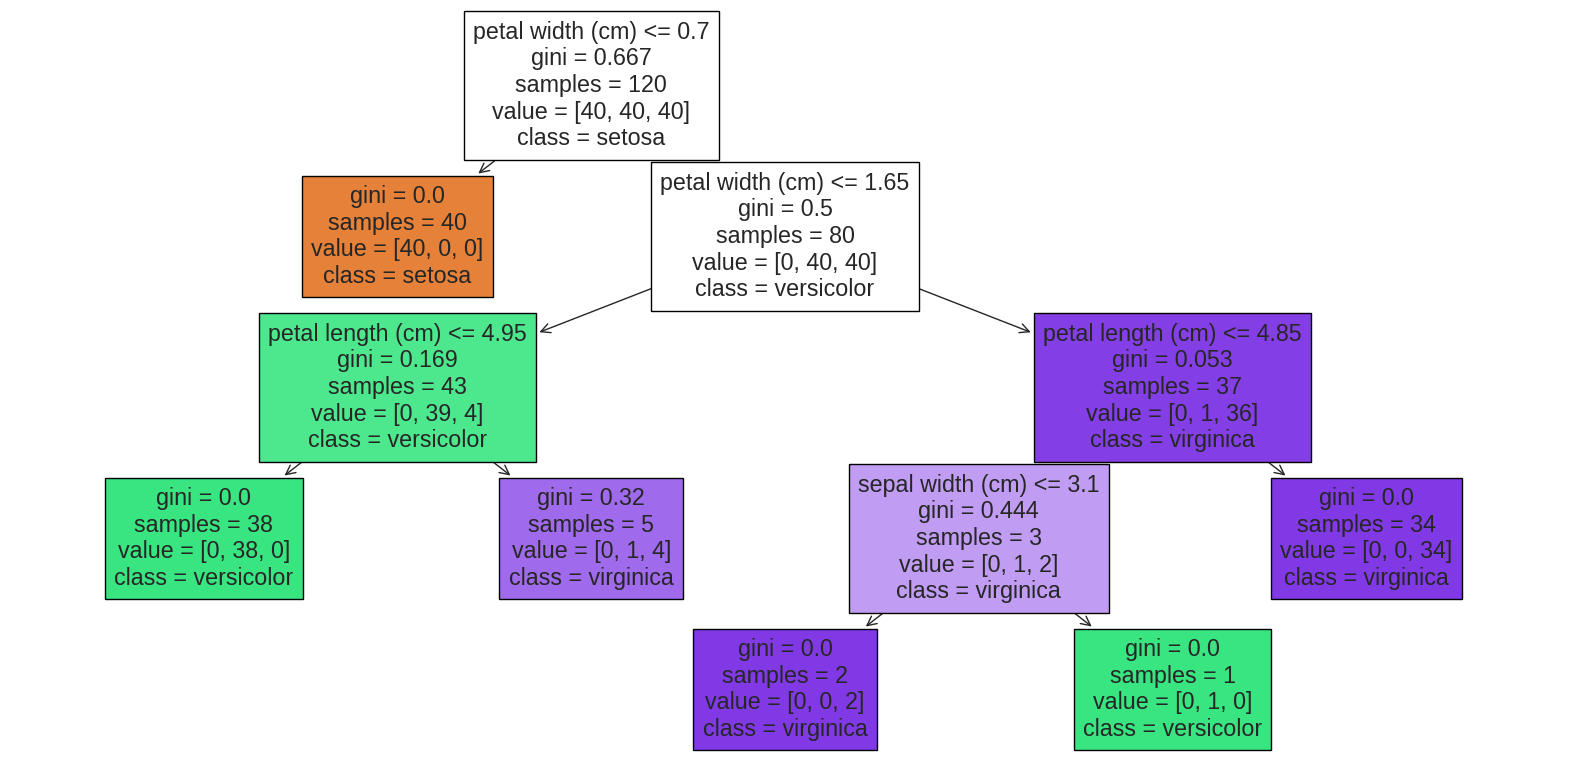

In [15]:
plt.figure(figsize=(20,10), dpi = 100)
tree.plot_tree(ccp_gs.best_estimator_, 
               feature_names=iris.feature_names,  
               class_names=iris.target_names,
               filled = True)
plt.show()

##### graphviz를 사용한 시각화

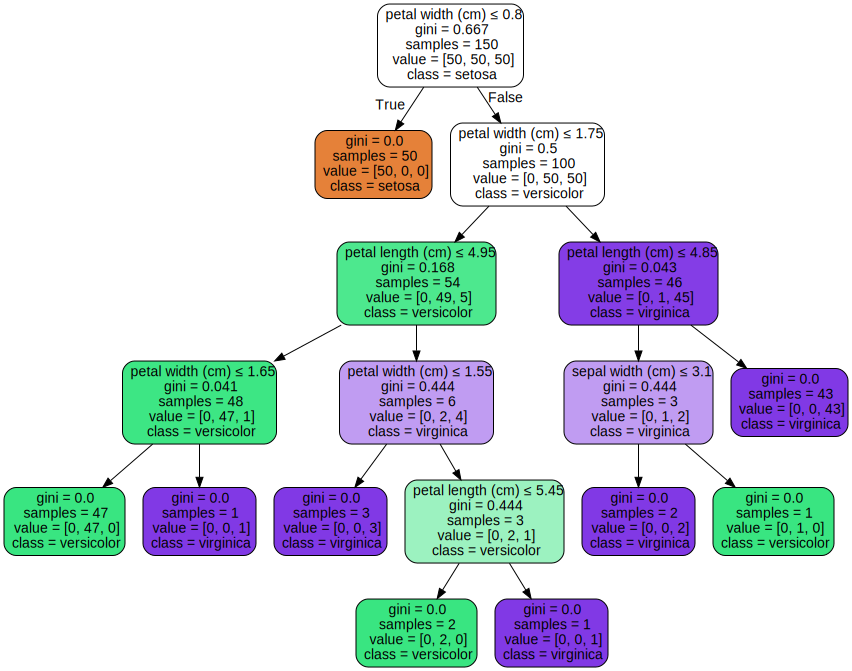

In [16]:
import graphviz 

dot_data = tree.export_graphviz(model,
                                feature_names = iris.feature_names,
                                class_names=iris.target_names,
                                filled = True, #색구분
                                rounded = True, #둥근 모서리
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

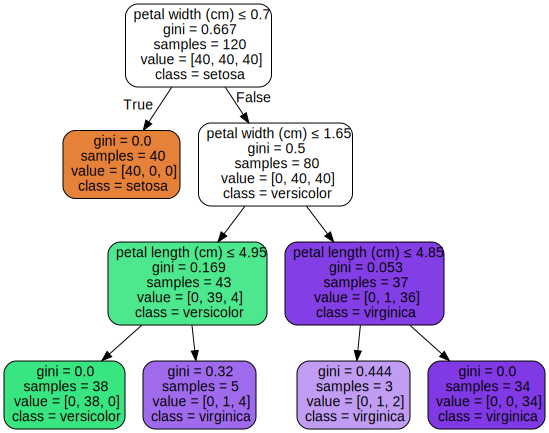

In [17]:
dot_data = tree.export_graphviz(gs.best_estimator_,
                                feature_names = iris.feature_names,
                                class_names=iris.target_names,
                                filled = True, #색구분
                                rounded = True, #둥근 모서리
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

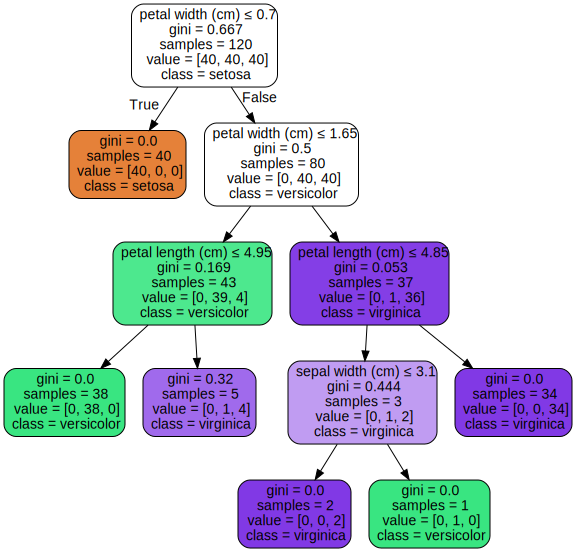

In [18]:
dot_data = tree.export_graphviz(ccp_gs.best_estimator_,
                                feature_names = iris.feature_names,
                                class_names=iris.target_names,
                                filled = True, #색구분
                                rounded = True, #둥근 모서리
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### 결정 경계 시각화

In [19]:
n_classes = 3
plot_colors = 'ryb'
plot_step = 0.02

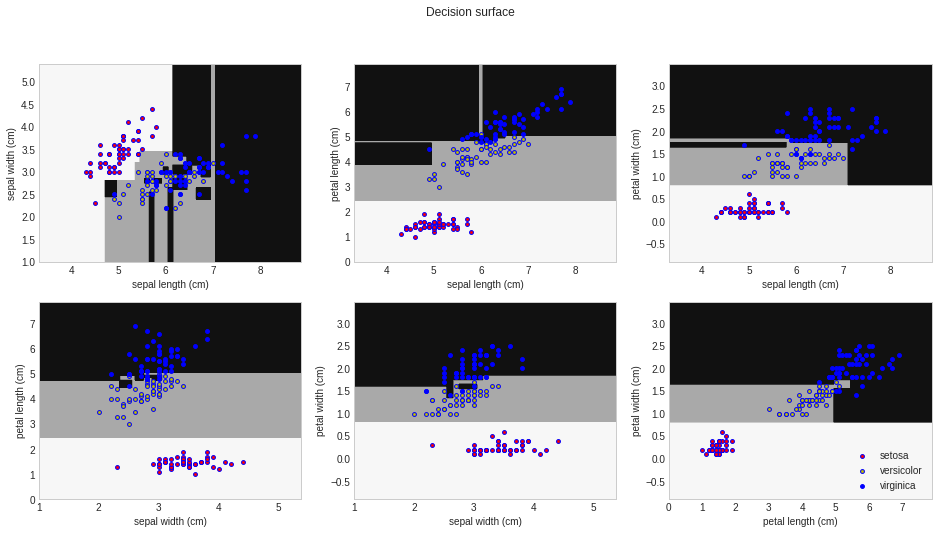

In [20]:
from matplotlib import cm

plt.figure(figsize=(16,8))

for pairidx, pair in enumerate([[0,1], [0,2], [0,3],
                                [1,2], [1,3], [2,3]]):
  X = iris.data[:, pair]
  y = iris.target

  model = DecisionTreeClassifier()
  model = model.fit(X,y)

  plt.subplot(2,3, pairidx + 1)

  x_min, x_max = X[:, 0].min()-1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min()-1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z)

  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])

  for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y==i)
    plt.scatter(X[idx,0], X[idx,1], color = color, label = iris.target_names[i],
                edgecolor = 'b', s = 15)
    
    
plt.suptitle('Decision surface')
plt.legend(loc = 'lower right')

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


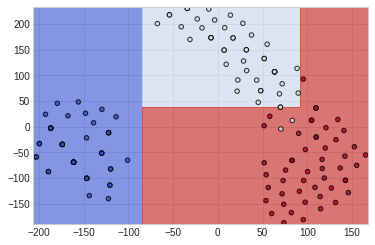

In [21]:
from sklearn.manifold import TSNE

X_comp = TSNE(n_components = 2).fit_transform(X)
x0, x1 = X_comp[:, 0], X_comp[:, 1]

xx0, xx1 = np.meshgrid(np.arange(x0.min()-3, x0.max()+3, 0.2),
                       np.arange(x1.min()-3, x1.max()+3, 0.2))

model = gs.best_estimator_
model.fit(X_comp, y)
print(model.get_params())

Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
Z = Z.reshape(xx0.shape)
plt.contourf(xx0, xx1, Z, cmap = plt.cm.coolwarm, alpha = 0.7)
plt.scatter(x0, x1, c = y, cmap = plt.cm.coolwarm, alpha = 0.8, s = 20, edgecolors='k')

## 회귀 - `DecisionTreeRegressor()`

### 하이퍼 파라미터

* criterion : {'squared_error', 'friedman_mse', 'absolute_error','poisson'}
  * ```default = 'squared_error'```

* max_depth : int
  *  ```default = None```
    + If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
  * the maximum depth of tree

* min_samples_split : int
  *  ```default = 2```
  * The minimum number of samples required to split an internal node

* min_samples_leaf : int or float
  * ```default = 1 ```
  * The minimum number of samples required to be at a leaf node.
  *  if min_smaples_leaf > min_samples_split then min_samples leaf consider first


* max_features : int, float, {“auto”, “sqrt”, “log2”}
  * ```default = None```
  * The number of features to consider when looking for the best split
  * tree를 형성할때 사용하는 features 의 갯수를 지정해 주는게 아니다 
  * 분할을 할때 고려할 features의 갯수를 지정해 주는것
  * overfitting 방지를 위해 사용

* max_leaf_nodes : int
  * ```default = None ```
  * 리프노드의 최대 갯수 설정

* ccp_alphanon-negative : float 
  * ```default=0.0```
  * post pruning method
  * overfitting 방지를 위해 사용

### 당뇨병 데이터 학습

In [22]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = load_diabetes(return_X_y = True)

In [23]:
d_df = pd.DataFrame(diabetes.data, columns = diabetes.feature_names)
d_df.insert(0, 'target', diabetes.target)
d_df

,target,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,141.0,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,206.0,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,135.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...,...
437,178.0,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,104.0,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,132.0,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,220.0,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 2023)

#### 모델 적합, 스코어 확인

In [25]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [26]:
from sklearn.model_selection import cross_validate
import sklearn.model_selection as ms

res = cv_res = cross_validate(model, 
                              X_train, y_train,
                              cv = ms.KFold(shuffle = True, random_state = 2023))
pd.DataFrame(res)

,fit_time,score_time,test_score
0,0.003569,0.001086,-0.512664
1,0.003202,0.000875,0.219301
2,0.002793,0.000909,-0.067256
3,0.003370,0.000911,-0.197954
4,0.003070,0.000968,-0.872532


#### 하이퍼파라미터 조절

##### parameter name

In [27]:
from sklearn.tree import DecisionTreeRegressor

DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### pre_pruning

In [28]:
from sklearn.model_selection import GridSearchCV
import multiprocessing
from sklearn.metrics import mean_squared_error

param_dict = {'criterion' : ['squared_error', 'friedman_mse'],
              'max_depth' : [2,3,4],
              'min_samples_split' : [2,3,4],
              'min_samples_leaf' : [1,2,3]}

gs = GridSearchCV(model, param_grid = param_dict,
                  cv = ms.KFold(shuffle = True, random_state = 2023),
                  n_jobs = multiprocessing.cpu_count())

gs.fit(X_train, y_train)

print(f'최적 파라미터 : {gs.best_estimator_}')
print(f'최종 점수 : {gs.score(X_test, y_test)}')
print(f'RMSE : {mean_squared_error(y_test, gs.predict(X_test))}')

res = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
res[['rank_test_score', 'mean_test_score', 'param_criterion',
     'param_min_samples_leaf', 'param_min_samples_split','param_max_depth']].head(5)

최적 파라미터 : DecisionTreeRegressor(max_depth=3)
최종 점수 : 0.3548286082986719
RMSE : 4513.868784342359


,rank_test_score,mean_test_score,param_criterion,param_min_samples_leaf,param_min_samples_split,param_max_depth
37,1,0.247237,friedman_mse,1,3,3
40,1,0.247237,friedman_mse,2,3,3
41,1,0.247237,friedman_mse,2,4,3
42,1,0.247237,friedman_mse,3,2,3
43,1,0.247237,friedman_mse,3,3,3


##### post-pruning

In [29]:
ccp_model = DecisionTreeRegressor()
path = ccp_model.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.00000000e+00, 1.41643059e-03, 1.41643059e-03, 1.41643059e-03,
        1.41643059e-03, 1.41643059e-03, 1.41643059e-03, 1.41643059e-03,
        1.41643059e-03, 1.41643059e-03, 1.41643059e-03, 1.88857413e-03,
        5.66572238e-03, 5.66572238e-03, 5.66572238e-03, 5.66572238e-03,
        5.66572238e-03, 5.66572238e-03, 5.66572238e-03, 5.66572238e-03,
        5.66572238e-03, 5.66572238e-03, 5.66572238e-03, 5.66572238e-03,
        5.66572238e-03, 9.06515581e-03, 1.15675165e-02, 1.27478754e-02,
        1.27478754e-02, 1.27478754e-02, 1.27478754e-02, 1.27478754e-02,
        1.27478754e-02, 1.27478754e-02, 2.26628895e-02, 2.26628895e-02,
        2.26628895e-02, 2.26628895e-02, 2.26628895e-02, 2.26628895e-02,
        2.26628895e-02, 2.26628895e-02, 2.26628895e-02, 2.26628895e-02,
        2.72898961e-02, 3.02171860e-02, 3.54107649e-02, 3.54107649e-02,
        3.54107649e-02, 3.54107649e-02, 3.54107649e-02, 3.54107649e-02,
        3.54107649e-02, 3.54107649e-02, 3.54107649

In [30]:
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as ms
import multiprocessing

ccp = path.ccp_alphas
param_dict = {'ccp_alpha' : ccp}

ccp_gs = GridSearchCV(ccp_model, 
                      param_grid = param_dict,
                      cv = ms.KFold(shuffle = True, random_state = 2023),
                      n_jobs = multiprocessing.cpu_count())

ccp_gs.fit(X_train, y_train)

print(f'최적 파라미터 : {ccp_gs.best_estimator_}')
print(f'최종 점수 : {ccp_gs.score(X_test, y_test)}')

res = pd.DataFrame(ccp_gs.cv_results_).sort_values('rank_test_score')
res[['rank_test_score', 'mean_test_score', 'param_ccp_alpha']].head(5)

최적 파라미터 : DecisionTreeRegressor(ccp_alpha=148.28094149395884)
최종 점수 : 0.357958148947938


,rank_test_score,mean_test_score,param_ccp_alpha
313,1,0.249831,148.280941
312,2,0.231191,112.309621
311,3,0.223761,104.08767
310,4,0.221325,98.051086
309,5,0.216895,93.861296


for문 이용

In [31]:
clfs = []
ccp_alphas = path.ccp_alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=2023, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

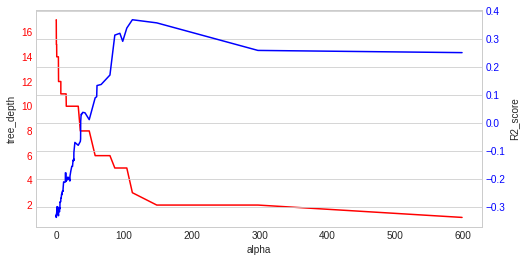

In [32]:
from sklearn.metrics import r2_score

tree_depths = [clf.tree_.max_depth for clf in clfs]
r2_scores = [r2_score(y_test, clf.predict(X_test)) for clf in clfs]

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.plot(ccp_alphas[:-1], tree_depths[:-1],'r')
ax2.plot(ccp_alphas[:-1], r2_scores[:-1],'b')

ax1.set_xlabel('alpha')
ax1.set_ylabel('tree_depth')
ax1.tick_params(axis = 'y', labelcolor = 'r')
ax1.grid(visible = None)

ax2.set_ylabel('R2_score')
ax2.tick_params(axis = 'y', labelcolor = 'b')


#### 결정 트리 시각화

##### 텍스트 시각화

In [33]:
from sklearn import tree

r = tree.export_text(decision_tree = model,
                     feature_names = diabetes.feature_names)
print(r)

|--- s5 <= -0.00
|   |--- bmi <= 0.01
|   |   |--- s5 <= -0.03
|   |   |   |--- age <= -0.09
|   |   |   |   |--- bp <= -0.06
|   |   |   |   |   |--- bmi <= -0.05
|   |   |   |   |   |   |--- value: [158.00]
|   |   |   |   |   |--- bmi >  -0.05
|   |   |   |   |   |   |--- value: [200.00]
|   |   |   |   |--- bp >  -0.06
|   |   |   |   |   |--- sex <= 0.00
|   |   |   |   |   |   |--- s5 <= -0.06
|   |   |   |   |   |   |   |--- s4 <= -0.04
|   |   |   |   |   |   |   |   |--- value: [101.00]
|   |   |   |   |   |   |   |--- s4 >  -0.04
|   |   |   |   |   |   |   |   |--- value: [113.00]
|   |   |   |   |   |   |--- s5 >  -0.06
|   |   |   |   |   |   |   |--- s5 <= -0.05
|   |   |   |   |   |   |   |   |--- value: [134.00]
|   |   |   |   |   |   |   |--- s5 >  -0.05
|   |   |   |   |   |   |   |   |--- value: [137.00]
|   |   |   |   |   |--- sex >  0.00
|   |   |   |   |   |   |--- s1 <= -0.06
|   |   |   |   |   |   |   |--- value: [71.00]
|   |   |   |   |   |   |--- s1 >  -0.

##### plot_tree

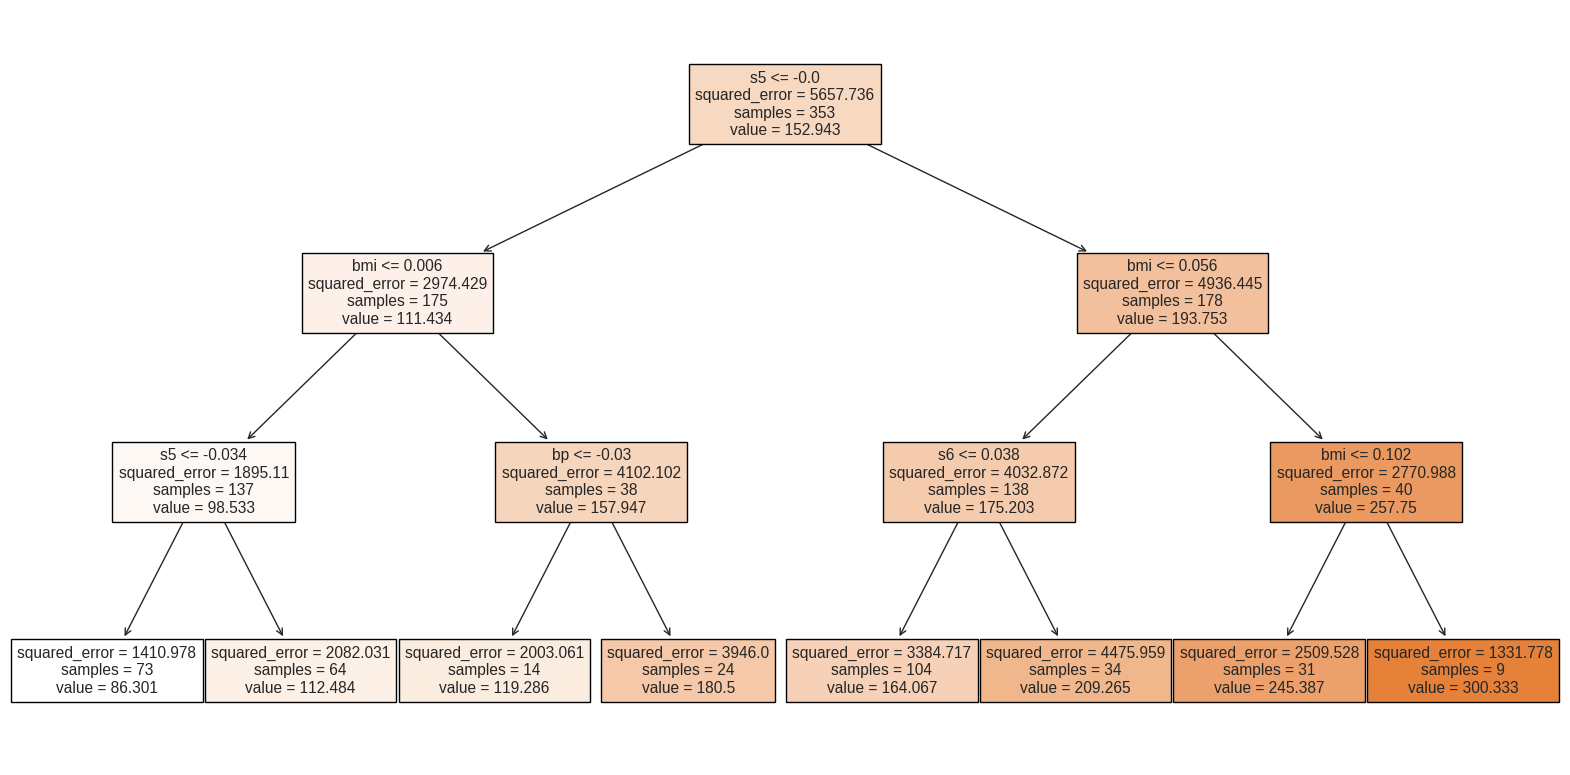

In [34]:
plt.figure(figsize=(20,10), dpi = 100)
tree.plot_tree(gs.best_estimator_, 
               feature_names = diabetes.feature_names, 
               filled = True)
plt.show()

##### graphviz를 사용한 시각화

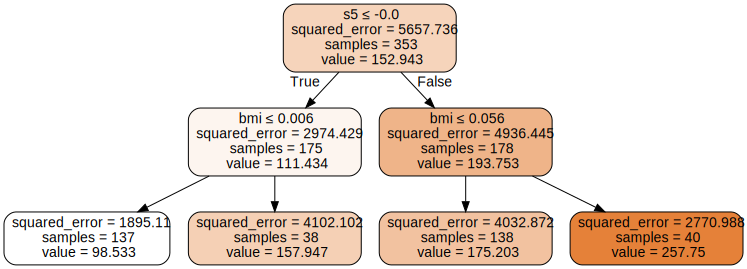

In [35]:
import graphviz 

dot_data = tree.export_graphviz(ccp_gs.best_estimator_,
                                feature_names = diabetes.feature_names,                         
                                filled = True, #색구분
                                rounded = True, #둥근 모서리
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### 결정 경계 시각화

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


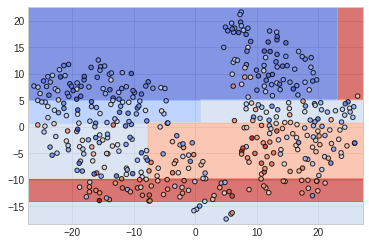

In [36]:
from sklearn.manifold import TSNE

X_comp = TSNE(n_components = 2).fit_transform(X)
x0, x1 = X_comp[:, 0], X_comp[:, 1]

xx0, xx1 = np.meshgrid(np.arange(x0.min()-1, x0.max()+1, 0.2),
                       np.arange(x1.min()-1, x1.max()+1, 0.2))

model = gs.best_estimator_
model.fit(X_comp, y)
print(model.get_params())

Z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
Z = Z.reshape(xx0.shape)
plt.contourf(xx0, xx1, Z, cmap = plt.cm.coolwarm, alpha = 0.7)
plt.scatter(x0, x1, c = y, cmap = plt.cm.coolwarm, alpha = 0.8, s = 20, edgecolors='k')